In [1]:
import torch


def dual_delta_test(impl_1, impl_2, oracle, generate_input, get_error, num_tests):
    delta_1 = []  # Error of impl_1 against the oracle
    delta_2 = []  # Error of impl_2 against the oracle
    for _ in range(num_tests):
        input = generate_input()
        res_1 = impl_1(*input)
        res_2 = impl_2(*input)
        res_oracle = oracle(*input)
        delta_1.append(get_error(res_1, res_oracle))
        delta_2.append(get_error(res_2, res_oracle))
    return delta_1, delta_2

In [2]:
def matmul_gpu(A, B):
    return torch.matmul(A, B)

def matmul_cpu(A, B):
    return torch.matmul(A.cpu(), B.cpu()).cuda()

def matmul_oracle(A, B):
    return torch.matmul(A.double(), B.double())

def generate_input():
    A = torch.randn(128, 128).half().cuda()
    B = torch.randn(128, 128).half().cuda()
    return A, B

# You can choose any error metric, such as max absolute/relative error, mean squared error, ULP error, etc.
def get_error(res, res_oracle):
    # using Max Hyb Error (https://github.com/peichenxie/HybError) as an example
    A = res.double()
    B = res_oracle.double()
    diff = (A-B).abs() / (1+B.abs())
    return diff.max().item()

# Running the dual delta test
delta_1, delta_2 = dual_delta_test(impl_1=matmul_gpu, impl_2=matmul_cpu, oracle=matmul_oracle, generate_input=generate_input, get_error=get_error, num_tests=1000)

In [3]:
# Example analysis: computing means and standard deviations
import numpy as np

mean_1, std_1 = np.mean(delta_1), np.std(delta_1)
mean_2, std_2 = np.mean(delta_2), np.std(delta_2)
print(f'GPU Implementation: Mean Error = {mean_1}, Std Dev = {std_1}')
print(f'CPU Implementation: Mean Error = {mean_2}, Std Dev = {std_2}')

GPU Implementation: Mean Error = 0.0004570837631177762, Std Dev = 6.079638819178954e-06
CPU Implementation: Mean Error = 0.0004570843924734295, Std Dev = 6.080521845755935e-06


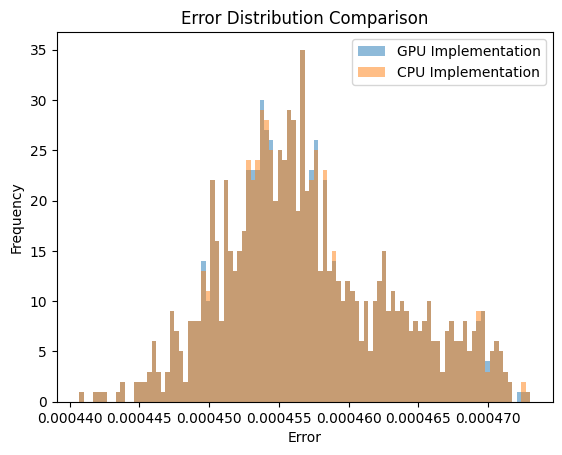

In [4]:
# Example analysis: visualizing the error distributions through histograms
import matplotlib.pyplot as plt
import numpy as np

_, bins = np.histogram(np.hstack((delta_1, delta_2)), bins=100)
plt.hist(delta_1, bins=bins.tolist(), alpha=0.5, label='GPU Implementation')
plt.hist(delta_2, bins=bins.tolist(), alpha=0.5, label='CPU Implementation')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Distribution Comparison')
plt.show()
